In [1]:
# Imports

import numpy as np
from matplotlib import pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.linear_model import LinearRegression

# Wrong lag, no latent confounder

## Bias in beta estimate

$X_t =aX_{t−1}+η_t$ \
​
$Y_t=bY{t−1} +cX_{t−τ_{true}} +γ_t$

Estimate: $Y_t​=βY_{t−1}​+αX_{t−τ_{assumed}}​+ε_t​$

In [2]:
def sigma_X2(a, sigma_eta2):
    return sigma_eta2 / (1 - a**2)

def A_k(a, b, k):
    if k >= 0:
        return a**k / (1 - a*b)
    else:
        m = -k
        if np.isclose(a, b):
            s = 0.0
            for j in range(2000):
                s += (b**j) * (a**(abs(j + k)))
            return s
        else:
            term1 = (a**(m+1) - a * b**m) / (a - b)
            term2 = b**m / (1 - a*b)
            return term1 + term2

def S_ab(a, b):
    return (1 + a*b) / ((1 - b**2) * (1 - a*b))

def analytic_coeffs(a, b, c, sigma_eta2, sigma_gamma2, tau_true, tau_assumed):
    k = tau_true - tau_assumed
    sigX2 = sigma_X2(a, sigma_eta2)
    A_k_val = A_k(a, b, k)
    A_k1_val = A_k(a, b, k+1)
    A1 = A_k(a, b, 1)
    S = S_ab(a, b)
    S_yy = c**2 * sigX2 * S + sigma_gamma2 / (1 - b**2)
    R_y = b * S_yy + c**2 * sigX2 * A1
    R_x = c * sigX2 * A_k_val
    S_yx = c * sigX2 * A_k1_val
    S_xx = sigX2
    Delta = S_yy * S_xx - S_yx**2
    
    beta = (R_y * S_xx - R_x * S_yx) / Delta
    alpha = (S_yy * R_x - S_yx * R_y) / Delta
    return beta, alpha

In [3]:
# Parameters
a = 0.7
b = 0.8   # true beta
c = 0.9
sigma_eta2 = 1.0
sigma_gamma2 = 0.5

taus_true = np.arange(0, 6)
taus_assumed = np.arange(0, 6)
matrix_percent = np.zeros((len(taus_true), len(taus_assumed)))  # rows: tau_true, cols: tau_assumed

for i, tau_true in enumerate(taus_true):
    for j, tau_assumed in enumerate(taus_assumed):
        beta_est, _ = analytic_coeffs(a, b, c, sigma_eta2, sigma_gamma2, tau_true, tau_assumed)
        percent_diff = (beta_est - b) / b * 100.0  # percent difference relative to true beta b
        matrix_percent[i, j] = percent_diff

In [4]:
# Plot heatmap
fig = go.Figure()

abs_max = np.nanmax(np.abs(matrix_percent))
fig.add_trace(go.Heatmap(z=matrix_percent, x=taus_true, y=taus_assumed, colorscale='RdBu_r',zmin=-abs_max, zmax=abs_max, colorbar=dict(title="Relative error of β (%)")))

for i, y_val in enumerate(taus_assumed):
    for j, x_val in enumerate(taus_true):
        fig.add_trace(go.Scatter(
            x=[x_val],
            y=[y_val],
            text=[f"{matrix_percent[i, j]:.1f}"],  # formatage à 1 décimale
            mode='text',
            showlegend=False,
            textfont=dict(color='black', size=12)
        ))

fig.update_layout(width=700, height=600, xaxis=dict(title="τ_true (true lag)", dtick=1), yaxis=dict(title="τ_assumed (tested lag)", dtick=1), title="Relative bias of estimated β as a function of τ_true and τ_assumed", template='plotly_white')
fig.show()

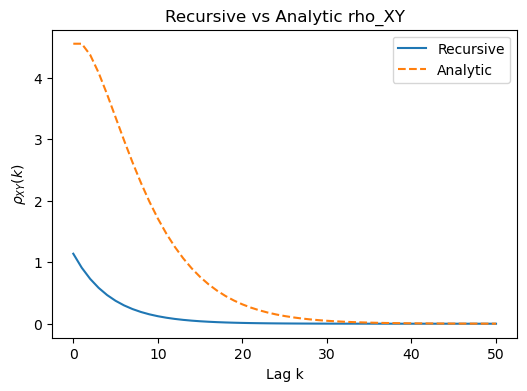

In [5]:
# --- Parameters ---
a = 0.8
b = 0.8
c = 0.8
sigma_X2 = 1.0
tau_true = 3
max_lag = 50

# --- Recursive computation ---
def compute_rho_XY(k, a, b, c, sigma_X2, tau_true, max_lag=100):
    rho = np.zeros(max_lag + 2)
    for i in range(max_lag, -1, -1):
        rho[i] = b * rho[i+1] + c * (a**(i + tau_true)) * sigma_X2
    return rho[:max_lag+1]

rho_rec = compute_rho_XY(0, a, b, c, sigma_X2, tau_true, max_lag)

# --- Analytic computation ---
def A_k(a, b, k):
    if np.isclose(a, b, atol=1e-12):
        # limit formula for a ~ b
        return (k+1) * a**k / (1 - a*b)
    else:
        return a**k / (1 - a*b)

rho_analytic = np.array([c * sigma_X2 * A_k(a, b, k + tau_true) for k in range(max_lag+1)])

# --- Relative error (signed) ---
rel_error = (rho_rec - rho_analytic) / rho_analytic

# --- Plot for visualization ---
plt.figure(figsize=(6,4))
plt.plot(range(max_lag+1), rho_rec, label="Recursive")
plt.plot(range(max_lag+1), rho_analytic, label="Analytic", linestyle="--")
plt.xlabel("Lag k")
plt.ylabel(r"$\rho_{XY}(k)$")
plt.legend()
plt.title("Recursive vs Analytic rho_XY")
plt.show()


# Bias in the slope

$X_t =a(t)X_{t−1}+η_t$ \
​
$Y_t=b(t)Y{t−1} +cX_{t−τ_{true}} +γ_t$

Estimate: $Y_t​=βY_{t−1}​+αX_{t−τ_{assumed}}​+ε_t​$

In [6]:
# -- Simulation function
def simulate_time_varying_tau(a0, a_end, b0, b_end, c, sigma_eta2, sigma_gamma2,
                          tau_true, N, burn=500, seed=1):
    """
    Simulate coupled AR(1) processes with slowly time-varying coefficients:
      X_t = a_t X_{t-1} + eta_t
      Y_t = b_t Y_{t-1} + c X_{t - tau_true} + gamma_t
    Returns:
        X[-N:], Y[-N:], a_t[-N:], b_t[-N:]  (all length N)
    """
    rng = np.random.default_rng(seed)
    total = N + burn + abs(tau_true)
    # desired slope on the returned N-block
    slope_a = (a_end - a0) / float(max(1, N - 1))
    slope_b = (b_end - b0) / float(max(1, N - 1))

    # build last-N linear sequences (these are the "true" returned sequences)
    a_ret = a0 + slope_a * np.arange(N)    # length N: from a0 -> a_end
    b_ret = b0 + slope_b * np.arange(N)    # length N: from b0 -> b_end

    # Prepend earlier values by linear extrapolation backwards so full array length == total
    pre_len = total - N
    if pre_len > 0:
        # for indices 0 .. pre_len-1, set values earlier than a0 by stepping back
        # so that a_ret[0] == a0 at position index pre_len in the full array
        a_pre = a0 - slope_a * np.arange(pre_len, 0, -1)  # length pre_len
        b_pre = b0 - slope_b * np.arange(pre_len, 0, -1)
        a_t = np.concatenate([a_pre, a_ret])
        b_t = np.concatenate([b_pre, b_ret])
    else:
        a_t = a_ret.copy()
        b_t = b_ret.copy()

    # safety: ensure lengths are correct
    assert len(a_t) == total
    assert len(b_t) == total

    # allocate and simulate
    X = np.zeros(total)
    Y = np.zeros(total)
    eta = rng.normal(scale=np.sqrt(sigma_eta2), size=total)
    gamma = rng.normal(scale=np.sqrt(sigma_gamma2), size=total)
    #X[0], Y[0] = 0.0, 0.0

    for t in range(1, total):
        X[t] = a_t[t] * X[t-1] + eta[t]
        idx = t - tau_true
        x_lag = X[idx] if idx >= 0 else 0.0
        Y[t] = b_t[t] * Y[t-1] + c * x_lag + gamma[t]

    # return last N samples (drop burn and any earlier prepended samples)
    return X[-N:], Y[-N:], a_t[-N:], b_t[-N:]

# -- Windowed beta estimation
def window_beta_estimates_tau(Y, X, tau_assumed, window_size=70, step=1):
    """
    Slide a window across Y and X, estimate beta in each window by OLS regressing:
      Y_t = beta * Y_{t-1} + alpha * X_{t - tau_assumed}
    Returns:
      betas: array of beta estimates (one per window)
      center_points: array of time indices (center of each window)
    """
    n = len(Y)
    betas = []
    center_points = []
    for start in range(0, n - window_size + 1, step):
        end = start + window_size
        Yw = Y[start:end]
        Xw = X[start:end]
        rows = []
        Ys = []
        maxlag = max(1, tau_assumed)
        # Build regression rows inside window, aligning indices so Yw[i] corresponds to time t
        for i in range(maxlag, window_size): # start from the first index where lags are defined
            y_t = Yw[i]
            y_lag = Yw[i-1]
            x_lag = Xw[i - tau_assumed]
            rows.append([y_lag, x_lag])
            Ys.append(y_t)
        A = np.asarray(rows, dtype=float)
        Yvec = np.asarray(Ys, dtype=float)
        reg = LinearRegression(fit_intercept=True).fit(A, Yvec)
        beta = reg.coef_[0]
        betas.append(float(beta))
        center_points.append(start + window_size // 2)
    return np.array(betas), np.array(center_points)


def compute_bias_matrix_tau(cfg, verbose=False):
    """Compute bias matrices and also return simulation outputs organized by (tau_true, tau_assumed).
    
    Returns:
      bias_matrix: (len(tau_assumed_vals), len(tau_true_vals)) array of percent bias
      stderr_matrix: same shape, percent stderr (from Monte-Carlo)
      tau_assumed_vals: 1d-array of tau_assumed values (rows)
      tau_true_vals: 1d-array of tau_true values (cols)
      sims_dict: dictionary mapping (tau_true, tau_assumed) -> list of simulation dicts. Each simulation dict contains:
          - 'X': simulated X array (length N)
          - 'Y': simulated Y array (length N)
          - 'a_t': array of a(t)
          - 'b_t': array of b(t)
          - 'betas': array of windowed beta estimates for this simulation
          - 'center_points': array of corresponding window-centers for beta estimates
          - 'slope': linear trend slope fitted to betas (or np.nan)
    """
    # unpack config
    a0 = cfg['a0']; a_end = cfg['a_end']
    b0 = cfg['b0']; b_end = cfg['b_end']
    c = cfg['c']
    sigma_eta2 = cfg['sigma_eta2']; sigma_gamma2 = cfg['sigma_gamma2']
    N = cfg['N']; window_size = cfg['window_size']; step = cfg['step']
    n_sims = cfg['n_sims']; burn = cfg['burn']
    tau_true_vals = cfg['tau_true_vals']; tau_assumed_vals = cfg['tau_assumed_vals']
    true_b_trend = (b_end - b0) / (N - 1)
    # prepare outputs
    bias_matrix = np.full((len(tau_assumed_vals), len(tau_true_vals)), np.nan)
    stderr_matrix = np.full_like(bias_matrix, np.nan, dtype=float)
    sims_dict = {}  # keys: (tau_true, tau_assumed) -> list of per-sim dicts
    total_cells = len(tau_assumed_vals) * len(tau_true_vals)
    cell_idx = 0
    # iterate grid
    for i_tau_assumed, tau_assumed in enumerate(tau_assumed_vals):
        for j_tau_true, tau_true in enumerate(tau_true_vals):
            cell_idx += 1
            if verbose:
                print(f"Computing cell {cell_idx}/{total_cells}: tau_assumed={tau_assumed}, tau_true={tau_true} ...", end=' ')
            slope_estimates = []
            sims_for_cell = []  # accumulate simulation outputs for this (tau_true, tau_assumed)
            for sim in range(n_sims):
                seed = sim
                Xs, Ys, at, bt = simulate_time_varying_tau(a0, a_end, b0, b_end,
                                                       c, sigma_eta2, sigma_gamma2,
                                                       tau_true, N, burn=burn, seed=seed)
                betas, center_points = window_beta_estimates_tau(Ys, Xs, tau_assumed, window_size=window_size, step=step)
                # fit slope if enough windows
                mask = ~np.isnan(betas)
                if mask.sum() < 3:
                    slope = np.nan
                else:
                    coeffs = np.polyfit(center_points[mask], betas[mask], 1)
                    slope = coeffs[0]
                    slope_estimates.append(slope)
                # store simulation outputs in a dict
                sim_rec = {
                    'X': Xs,
                    'Y': Ys,
                    'a_t': at,
                    'b_t': bt,
                    'betas': betas,
                    'center_points': center_points,
                    'slope': slope
                }
                sims_for_cell.append(sim_rec)
            # compute summary statistics for this cell
            slope_estimates = np.array(slope_estimates)
            mean_slope = np.nanmean(slope_estimates)
            std_slope = np.nanstd(slope_estimates, ddof=1)
            bias = mean_slope - true_b_trend
            pct_bias = 100.0 * bias / true_b_trend if true_b_trend != 0 else np.nan
            bias_matrix[i_tau_assumed, j_tau_true] = pct_bias
            stderr_matrix[i_tau_assumed, j_tau_true] = 100.0 * std_slope / true_b_trend if true_b_trend != 0 else np.nan
            sims_dict[(int(tau_true), int(tau_assumed))] = sims_for_cell
    return bias_matrix, stderr_matrix, np.array(tau_assumed_vals), np.array(tau_true_vals), sims_dict


def plotly_heatmap_tau(bias_matrix, tau_assumed_vals, tau_true_vals):
    text = [[(f"{val:.1f}%" if (not np.isnan(val)) else "nan") for val in row] for row in bias_matrix]
    
    abs_max = np.nanmax(np.abs(bias_matrix))
    # build heatmap
    fig = go.Figure(data=go.Heatmap(
        z=bias_matrix, x=list(tau_true_vals), y=list(tau_assumed_vals),
        text=text, texttemplate="%{text}", colorscale='RdBu_r',
        zmin=-abs_max, zmax=abs_max, colorbar=dict(title='Bias (%)')
    ))
    fig.update_layout(title='Percent bias in slope estimate of beta (%)', xaxis_title=r'τ_true', yaxis_title=r'τ_assumed',
                      autosize=True, width=620, height=600)
    return fig

In [8]:
CONFIG = {
    'a0': 0.12, 'a_end': 0.58,        # a(t) evolves linearly from a0 -> a_end
    'b0': 0.1, 'b_end': 0.6,         # b(t) evolves linearly from b0 -> b_end
    'c': -0.5,
    'sigma_eta2': 0.5,
    'sigma_gamma2': 0.5,
    'N': 1000,                      # total length of retained series (large => slower true trend)
    'window_size': 100,              # stationary window size
    'step': 1,                     # sliding step for windows
    'n_sims': 200,                    # monte-carlo replicates (increase for precision)
    'tau_true_vals': list(range(0,6)),  # 0..5
    'tau_assumed_vals': list(range(0,6)),   # 0..5
    'burn': 10,
    }

In [9]:
bias_matrix, stderr_matrix, tau_assumed_vals, tau_true_vals, sims_dict = compute_bias_matrix_tau(CONFIG)

In [10]:
fig_heatmap = plotly_heatmap_tau(bias_matrix, tau_assumed_vals, tau_true_vals)

In [12]:
fig_heatmap.show()

In [81]:
def make_cell_traces(sims_for_cell, max_sims_to_plot=None):
    sims_to_plot = sims_for_cell if max_sims_to_plot is None else sims_for_cell[:max_sims_to_plot]
    traces_X, traces_Y, traces_beta = [], [], []
    meta = {'a_t': None, 'b_t': None}
    for k, rec in enumerate(sims_to_plot):
        X = rec.get('X')
        if X is not None:
            x_axis = np.arange(len(X))
            traces_X.append(go.Scatter(x=x_axis, y=X, mode='lines',
                                       name=f'X (sim {k+1})', showlegend=False,
                                       hoverinfo='skip'))
        Y = rec.get('Y')
        if Y is not None:
            x_axis = np.arange(len(Y))
            traces_Y.append(go.Scatter(x=x_axis, y=Y, mode='lines',
                                       name=f'Y (sim {k+1})', showlegend=False,
                                       hoverinfo='skip'))
        betas = rec.get('betas')
        center_points = rec.get('center_points')
        if betas is not None and center_points is not None:
            traces_beta.append(go.Scatter(x=center_points, y=betas, mode='lines+markers',
                                          name=f'beta (sim {k+1})', showlegend=False,
                                          hoverinfo='skip'))
        # capture a_t and b_t from first simulation if present
        if k == 0:
            if rec.get('a_t') is not None:
                meta['a_t'] = rec.get('a_t')
            if rec.get('b_t') is not None:
                meta['b_t'] = rec.get('b_t')
    return traces_X, traces_Y, traces_beta, meta

def plot_single_cell(sim_dict, tau_true, tau_assumed, max_sims_to_plot=None):
    traces_X, traces_Y, traces_beta, meta = make_cell_traces(sim_dict[(tau_true, tau_assumed)], max_sims_to_plot=max_sims_to_plot)
    colors = px.colors.qualitative.Prism
    fixed_colors = [colors[(i+1) % len(colors)] for i in range(200)]

    fig = make_subplots(rows=3, cols=1, shared_xaxes=True,
                        vertical_spacing=0.03,)
    for i, tr in enumerate(traces_X):
        fig.add_trace(go.Scatter(tr, mode='lines', line=dict(color=fixed_colors[i]), opacity=0.5), row=1, col=1)
    for i, tr in enumerate(traces_Y):
        fig.add_trace(go.Scatter(tr, mode='lines', line=dict(color=fixed_colors[i]), opacity=0.5), row=2, col=1)
    for i, tr in enumerate(traces_beta):
        fig.add_trace(go.Scatter(tr, mode='lines', line=dict(color=fixed_colors[i]), opacity=0.5), row=3, col=1)
    fig.add_trace(go.Scatter(y=meta['b_t'], mode='lines', line=dict(color='white')), row=3, col=1)

    fig.update_layout(title=f'tau_true={tau_true}, tau_assumed={tau_assumed}',
                      width=500, height=600, template='plotly_white', showlegend=False)
    fig.update_yaxes(title_text=f"X", row=1, col=1)
    fig.update_yaxes(title_text=f"Y", row=2, col=1)
    fig.update_yaxes(title_text=f"Beta", row=3, col=1)
    return fig

In [ ]:
tau_true, tau_assumed = 3, 1
fig_cell = plot_single_cell(sims_dict, tau_true, tau_assumed, max_sims_to_plot=30)
fig_cell.show()

# Right lag, latent confounder


X and Y are coupled AR(1) with a latent confounder that induces cross-time covariance between noise terms.

This version lets both a(t) and b(t) vary linearly in time:

$X_t = a(t) * X_{t-1} + \eta_t$

$Y_t = b(t) * Y_{t-1} + c * X_{t-tau} + \gamma_t$

$a(t) = a0 + s_a * t$

$b(t) = b0 + s_b * t$

Latent confounder $Z_t$ is AR(1): $Z_t = \phi * Z_{t-1} + \epsilon_t$

$\eta_t = \sigma_{\eta} * z_{1t} + p * u_t$

$\gamma_t = \sigma_{\gamma} * z_{2t} + q * u_t$

In [48]:
def simulate_time_varying_confounder(a0, a_end, b0, b_end, c,
                                     sigma_eta2, sigma_gamma2,
                                     p, q, phi, tau_true, N, burn=0, seed=0):
    """
    Simulate one realization of the time-varying AR(1) coupled system with a latent confounder.
    - p is the coefficient of Z_t in eta_t
    - q is the coefficient of Z_t in gamma_t
    Returns last N samples for X and Y and the corresponding a_t, b_t (length N).
    """
    rng = np.random.default_rng(seed)
    total = N + burn + abs(tau_true)
    # slopes for a and b over the returned N-block
    slope_a = (a_end - a0) / float(max(1, N - 1))
    slope_b = (b_end - b0) / float(max(1, N - 1))

    # build last-N linear sequences
    a_ret = a0 + slope_a * np.arange(N)
    b_ret = b0 + slope_b * np.arange(N)

    # prepend earlier values so full length == total
    pre_len = total - N
    a_pre = a0 - slope_a * np.arange(pre_len, 0, -1) if pre_len > 0 else np.array([])
    b_pre = b0 - slope_b * np.arange(pre_len, 0, -1) if pre_len > 0 else np.array([])
    a_t = np.concatenate([a_pre, a_ret]) if pre_len > 0 else a_ret.copy()
    b_t = np.concatenate([b_pre, b_ret]) if pre_len > 0 else b_ret.copy()

    # simulate latent Z (AR(1)) with white noise ~ N(0,1)
    eps = rng.normal(size=total)
    Z = np.zeros(total)
    for t in range(1, total):
        Z[t] = phi * Z[t-1] + eps[t]

    z1 = rng.normal(size=total)
    z2 = rng.normal(size=total)
    eta = np.sqrt(sigma_eta2) * z1 + p * Z
    gamma = np.sqrt(sigma_gamma2) * z2 + q * Z

    X = np.zeros(total)
    Y = np.zeros(total)

    for t in range(1, total):
        X[t] = a_t[t] * X[t-1] + eta[t]
        Y[t] = b_t[t] * Y[t-1] + c * X[t - tau_true] + gamma[t]

    # return last N samples
    return X[-N:], Y[-N:], a_t[-N:], b_t[-N:]


def window_beta_estimates_confounder(Y, X, tau, window_size, step=1):
    """
    Sliding-window OLS estimates of beta in regression
      Y_t ~ beta * Y_{t-1} + alpha * X_{t - tau}
    Returns:
      betas: array of estimated beta for each window (np.nan if regression fails)
      center_points: array of center indices (integers)
    Notes:
      - requires at least a few valid rows per window (handled by sklearn).
      - rows where the lagged X index would be negative are skipped.
    """
    N = len(X)
    center_points = []
    betas = []

    for start in range(0, N - window_size + 1, step):
        end = start + window_size
        Yw = Y[start:end]
        Xw = X[start:end]
        rows = []
        Ys = []
        # build rows: index i corresponds to time t = start + i
        for i in range(1, window_size):  # y_{t-1} defined for i>=1
            # check X lag availability within the window
            if (i - tau) < 0:
                continue
            y_t = Yw[i]
            y_lag = Yw[i-1]
            x_lag = Xw[i - tau]
            rows.append([y_lag, x_lag])
            Ys.append(y_t)

        if len(rows) < 3:  # not enough data to get a stable estimate
            betas.append(np.nan)
            center_points.append(start + window_size // 2)
            continue

        A = np.asarray(rows, dtype=float)
        Yvec = np.asarray(Ys, dtype=float)
        reg = LinearRegression(fit_intercept=True).fit(A, Yvec)
        beta_est = float(reg.coef_[0])  # coefficient for y_{t-1}
        betas.append(beta_est)
        center_points.append(start + window_size // 2)

    return np.array(betas, dtype=float), np.array(center_points, dtype=float)


def compute_bias_matrix_confounder(cfg, verbose=False):
    """
    Compute bias matrix over grid of p and q for a fixed phi.
    cfg expects keys:
      - a0, a_end, b0, b_end
      - c
      - sigma_eta2, sigma_gamma2
      - N, window_size, step
      - n_sims, burn
      - tau_true (int)
      - p_vals (iterable)
      - q_vals (iterable)
      - phi (float)  # fixed
    Returns:
      bias_matrix (shape len(q_vals) x len(p_vals)) in percent,
      stderr_matrix (same shape) in percent,
      np.array(q_vals), np.array(p_vals), sims_dict
    """
    a0 = float(cfg['a0']); a_end = float(cfg['a_end'])
    b0 = float(cfg['b0']); b_end = float(cfg['b_end'])
    c = float(cfg['c'])
    sigma_eta2 = float(cfg['sigma_eta2']); sigma_gamma2 = float(cfg['sigma_gamma2'])
    N = int(cfg['N']); window_size = int(cfg['window_size']); step = int(cfg.get('step', 1))
    n_sims = int(cfg['n_sims']); burn = int(cfg.get('burn', 0))
    tau_true = int(cfg['tau_true'])
    p_vals = list(cfg['p_vals'])
    q_vals = list(cfg['q_vals'])
    phi = float(cfg['phi'])

    true_b_trend = (b_end - b0) / float(N - 1)

    bias_matrix = np.full((len(q_vals), len(p_vals)), np.nan, dtype=float)
    stderr_matrix = np.full_like(bias_matrix, np.nan, dtype=float)
    sims_dict = {}

    total_cells = len(q_vals) * len(p_vals)
    cell_idx = 0

    for i_q, q in enumerate(q_vals):
        for j_p, p in enumerate(p_vals):
            cell_idx += 1
            if verbose:
                print(f"[{cell_idx}/{total_cells}] phi={phi}, p={p}, q={q} ...", end=' ')
            slopes = []
            sims_for_cell = []
            for sim_idx in range(n_sims):
                seed = sim_idx + i_q * 10 + j_p * 100
                Xs, Ys, at, bt = simulate_time_varying_confounder(
                    a0, a_end, b0, b_end, c,
                    sigma_eta2, sigma_gamma2,
                    float(p), float(q), float(phi), int(tau_true),
                    N, burn=burn, seed=seed
                )
                betas, centers = window_beta_estimates_confounder(Ys, Xs, int(tau_true), window_size=window_size, step=step)
                mask = ~np.isnan(betas)
                if mask.sum() < 3:
                    slope = np.nan
                else:
                    coeffs = np.polyfit(centers[mask], betas[mask], 1)
                    slope = float(coeffs[0])
                    slopes.append(slope)
                sim_rec = {
                    'X': Xs,
                    'Y': Ys,
                    'a_t': at,
                    'b_t': bt,
                    'betas': betas,
                    'center_points': centers,
                    'slope': slope
                }
                sims_for_cell.append(sim_rec)
            sims_dict[(float(p), float(q))] = sims_for_cell
            slopes_arr = np.array(slopes, dtype=float)
            if slopes_arr.size == 0:
                mean_slope = np.nan
                std_slope = np.nan
            else:
                mean_slope = float(np.nanmean(slopes_arr))
                std_slope = float(np.nanstd(slopes_arr, ddof=(1 if slopes_arr.size>1 else 0)))
            bias = mean_slope - true_b_trend
            pct_bias = 100.0 * bias / true_b_trend if true_b_trend != 0 else np.nan
            pct_stderr = 100.0 * std_slope / true_b_trend if true_b_trend != 0 else np.nan
            bias_matrix[i_q, j_p] = pct_bias
            stderr_matrix[i_q, j_p] = pct_stderr
            if verbose:
                print(f"done. pct_bias={pct_bias:.2f}% (n_valid={len(slopes_arr)})")
    return bias_matrix, stderr_matrix, np.array(q_vals), np.array(p_vals), sims_dict


In [49]:
config = {
    'a0': 0.12, 'a_end': 0.58,
    'b0': 0.1, 'b_end': 0.6,
    'c': 0.5, 'phi': 0.5,
    'sigma_eta2': 1, 'sigma_gamma2': 1,
    'N': 1000, 'window_size': 100, 'step': 1,
    'n_sims': 200, 'burn': 10,
    'tau_true': 1,
    'p_vals': [-0.9, -0.5, 0.0, 0.5, 0.9],
    'q_vals': [-0.9, -0.5, 0.0, 0.5, 0.9],
}

In [50]:
bias_matrix, stderr_matrix, p_vals, q_vals, sims_dict = compute_bias_matrix_confounder(config)

In [51]:
def plot_bias_heatmap_confounder(bias_matrix, p_vals, q_vals):    
    text = [[(f"{val:.1f}%" if (not np.isnan(val)) else "nan") for val in row] for row in bias_matrix]
    abs_max = np.nanmax(np.abs(bias_matrix))

    x_labels = [f"{v:.1f}" for v in p_vals]
    y_labels = [f"{v:.1f}" for v in q_vals]

    fig = go.Figure(data=go.Heatmap(
        z=bias_matrix, x=x_labels, y=y_labels,
        text=text, texttemplate="%{text}",
        colorscale="RdBu_r", colorbar=dict(title="Bias (%)"),
        zmin=-abs_max, zmax=abs_max
    ))

    fig.update_layout(
        title="Percent bias in slope estimate of beta (%)",
        xaxis_title="p", yaxis_title="q",
        xaxis=dict(type="category"), yaxis=dict(type="category"),
        width=500, height=500, template="plotly_white", autosize=True)
    return fig

In [52]:
fig = plot_bias_heatmap_confounder(bias_matrix, p_vals, q_vals)
fig.show()

# Detrending impacts

In [17]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from numpy.linalg import inv, lstsq

np.random.seed(42)

# -------------------- Parameters --------------------
N = 200                # total time points
wl = 50                # sliding window length
step = 1               # step of sliding windows
tau = 2                # delay from X to Y
a0, a1 = 0.2, 0.6      # AR(1) parameter for X slowly changing
b0, b1 = 0.4, 0.9      # AR(1) parameter for Y slowly changing
c_true = 0.8           # true coupling X -> Y
m_slope = 0.02         # slope of deterministic input m_t (non-stationary component)
sigma_eta = 0.5
sigma_gamma = 0.5

# -------------------- Generate time-varying coefficients and m_t --------------------
t = np.arange(N)
a_t = a0 + (a1 - a0) / (N - 1) * t
b_t = b0 + (b1 - b0) / (N - 1) * t
m_t = m_slope * t

# -------------------- Simulate X and Y --------------------
X = np.zeros(N)
Y = np.zeros(N)
eta = np.random.normal(0, sigma_eta, size=N)
gamma = np.random.normal(0, sigma_gamma, size=N)

for tt in range(1, N):
    X[tt] = a_t[tt] * X[tt-1] + m_t[tt] + eta[tt]
    x_lag = X[tt-tau] if tt-tau >= 0 else 0.0
    Y[tt] = b_t[tt] * Y[tt-1] + c_true * x_lag + gamma[tt]

# -------------------- Sliding windows --------------------
starts = np.arange(0, N - wl + 1, step)
time_windows = [np.arange(s, s + wl) for s in starts]

def detrend_series(series):
    """Remove mean and linear trend from a 1D array."""
    x = np.array(series, dtype=float)
    x = x - x.mean()
    slope, intercept = np.polyfit(np.arange(len(x)), x, 1)
    trend = slope * np.arange(len(x)) + intercept
    return x - trend

def window_regression(X_full, Y_full, window, tau, detrend=False):
    idx = np.array(window)
    s, e = idx[0], idx[-1]
    t_valid = np.arange(s + max(1, tau), e + 1)
    if len(t_valid) == 0:
        return None, None, 0

    Yw = Y_full[idx].copy()
    Xw = X_full[idx].copy()
    if detrend:
        Yw = detrend_series(Yw)
        Xw = detrend_series(Xw)

    Y_t = np.array([Yw[t - s] for t in t_valid])
    Y_lag = np.array([Yw[t - 1 - s] for t in t_valid])
    X_lag = np.array([Xw[t - tau - s] for t in t_valid])

    Z = np.column_stack([np.ones(len(Y_t)), Y_lag, X_lag])
    beta_hat, *_ = lstsq(Z, Y_t, rcond=None)
    resid = Y_t - Z.dot(beta_hat)
    n, k = len(Y_t), Z.shape[1]
    if n - k <= 0:
        se = np.full(k, np.nan)
    else:
        s2 = resid.dot(resid) / (n - k)
        cov = s2 * inv(Z.T.dot(Z))
        se = np.sqrt(np.diag(cov))
    return beta_hat, se, n

# -------------------- Collect estimates --------------------
center_times = []
b_est_no = []; b_est_dt = []
c_est_no = []; c_est_dt = []

for window in time_windows:
    if window[-1] >= len(X):
        break
    center_times.append(window.mean())

    coef_no, se_no, _ = window_regression(X, Y, window, tau, detrend=False)
    coef_dt, se_dt, _ = window_regression(X, Y, window, tau, detrend=True)

    if coef_no is not None:
        b_est_no.append(coef_no[1]); c_est_no.append(coef_no[2])
    else:
        b_est_no.append(np.nan); c_est_no.append(np.nan)
    if coef_dt is not None:
        b_est_dt.append(coef_dt[1]); c_est_dt.append(coef_dt[2])
    else:
        b_est_dt.append(np.nan); c_est_dt.append(np.nan)

center_times = np.array(center_times)
b_est_no = np.array(b_est_no); b_est_dt = np.array(b_est_dt)
c_est_no = np.array(c_est_no); c_est_dt = np.array(c_est_dt)
b_true_centers = np.interp(center_times, t, b_t)

# -------------------- Subplots --------------------
fig = make_subplots(
    rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05,
    subplot_titles=[
        "Séries temporelles X et Y",
        f"Coefficient autoregressif local b̂ (fenêtre={wl})",
        f"Coefficient de couplage local ĉ (fenêtre={wl})"
    ]
)

# 1) X and Y
fig.add_trace(go.Scatter(x=t, y=X, mode='lines', name='X', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=t, y=Y, mode='lines', name='Y', line=dict(color='red')), row=1, col=1)

# 2) b estimates
fig.add_trace(go.Scatter(x=center_times, y=b_est_no, mode='lines+markers',
                         name='b̂ (no detrend)', line=dict(color='gray')), row=2, col=1)
fig.add_trace(go.Scatter(x=center_times, y=b_est_dt, mode='lines+markers',
                         name='b̂ (detrend)', line=dict(color='black')), row=2, col=1)
fig.add_trace(go.Scatter(x=center_times, y=b_true_centers, mode='lines',
                         name='b_true', line=dict(color='green', dash='dash')), row=2, col=1)

# 3) c estimates
fig.add_trace(go.Scatter(x=center_times, y=c_est_no, mode='lines+markers',
                         name='ĉ (no detrend)', line=dict(color='orange')), row=3, col=1)
fig.add_trace(go.Scatter(x=center_times, y=c_est_dt, mode='lines+markers',
                         name='ĉ (detrend)', line=dict(color='red')), row=3, col=1)
fig.add_trace(go.Scatter(x=center_times, y=np.full_like(center_times, c_true),
                         mode='lines', name='c_true', line=dict(color='green', dash='dash')), row=3, col=1)

# Layout
fig.update_layout(
    height=900, width=900,
    title_text="Expérience glissante : effet du detrending sur les coefficients locaux",
    showlegend=True,
    legend=dict(yanchor="top", y=1.05, xanchor="left", x=0.01)
)
fig.update_xaxes(title_text="Temps (t)", row=3, col=1)
fig.update_yaxes(title_text="Valeur", row=1, col=1)
fig.update_yaxes(title_text="b̂", row=2, col=1)
fig.update_yaxes(title_text="ĉ", row=3, col=1)

fig.show()
